In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.options.display.max_colwidth = 500
%matplotlib inline

In [2]:
test_df = pd.read_csv('image_test_dataset.tsv', delimiter='\t')
total_test_samples = test_df.shape[0]
total_test_samples

5000

In [3]:
from keras.models import load_model

model1 = load_model('ic_model_rmsprop_b256ep30.h5')
model2 = load_model('ic_model_rmsprop_b256ep50.h5')

C:\Program Files\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
from sklearn.externals import joblib

tl_img_feature_map = joblib.load('transfer_learn_img_features.pkl')
vocab_metadata = joblib.load('vocabulary_metadata.pkl')
word_to_index = vocab_metadata['word2index']
index_to_word = vocab_metadata['index2word']
max_caption_size = vocab_metadata['max_caption_size']
vocab_size = vocab_metadata['vocab_size']

In [5]:
test_df.head()

image                                         caption
0  3385593926_d3e9c21170.jpg  The dogs are in the snow in front of a fence .
1  3385593926_d3e9c21170.jpg                     The dogs play on the snow .
2  3385593926_d3e9c21170.jpg    Two brown dogs playfully fight in the snow .
3  3385593926_d3e9c21170.jpg            Two brown dogs wrestle in the snow .
4  3385593926_d3e9c21170.jpg                  Two dogs playing in the snow .

In [6]:
from keras.preprocessing import image, sequence

def get_raw_caption_sequences(model, word_to_index, image_features, max_caption_size, beam_size=1):
    
    start = [word_to_index['<START>']]
    caption_seqs = [[start, 0.0]]

    while len(caption_seqs[0][0]) < max_caption_size:
        temp_caption_seqs = []
        for caption_seq in caption_seqs:
            partial_caption_seq = sequence.pad_sequences([caption_seq[0]], maxlen=max_caption_size, padding='post')
            next_words_pred = model.predict([np.asarray([image_features]), np.asarray(partial_caption_seq)])[0]
            next_words = np.argsort(next_words_pred)[-beam_size:]

            for word in next_words:
                new_partial_caption, new_partial_caption_prob = caption_seq[0][:], caption_seq[1]
                new_partial_caption.append(word)
                new_partial_caption_prob += next_words_pred[word]
                temp_caption_seqs.append([new_partial_caption, new_partial_caption_prob])
                
        caption_seqs = temp_caption_seqs
        caption_seqs.sort(key = lambda item: item[1])
        caption_seqs = caption_seqs[-beam_size:]
        
    return caption_seqs  

In [7]:
def generate_image_caption(model, word_to_index_map, index_to_word_map, image_features, max_caption_size, beam_size=1):
    
    raw_caption_seqs = get_raw_caption_sequences(model=model, word_to_index=word_to_index_map, 
                                             image_features=image_features, 
                                             max_caption_size=max_caption_size, beam_size=beam_size)
    raw_caption_seqs.sort(key = lambda l: -l[1])
    caption_list = [item[0] for item in raw_caption_seqs]
    captions = [[index_to_word_map[idx] for idx in caption] for caption in caption_list]
    
    final_captions = []
    for caption in captions:
        start_index = caption.index('<START>')+1
        max_len = len(caption) if len(caption) < max_caption_size else max_caption_size
        end_index = caption.index('<END>') if '<END>' in caption else max_len-1
        proc_caption = ' '.join(caption[start_index:end_index])
        final_captions.append(proc_caption)
    
    return final_captions

In [8]:
def preprocess_captions(caption_list):
    pc = []
    for caption in caption_list:
        caption = caption.strip().lower()
        caption = caption.replace('.', '').replace(',', '').replace("'", "").replace('"', '')
        caption = caption.replace('&','and').replace('(','').replace(')', '').replace('-', ' ')
        caption = ' '.join(caption.split()) 
        pc.append(caption)
    return pc

In [27]:
from nltk.translate.bleu_score import corpus_bleu

def compute_bleu_evaluation(reference_captions, predicted_captions):
    actual_caps = [[caption.split() for caption in sublist] for sublist in reference_captions]
    predicted_caps = [caption.split() for caption in predicted_captions]
    
    bleu1 = corpus_bleu(actual_caps, predicted_caps, weights=(1.0, 0, 0, 0))
    bleu2 = corpus_bleu(actual_caps, predicted_caps, weights=(0.5, 0.5, 0, 0))
    bleu3 = corpus_bleu(actual_caps, predicted_caps, weights=(0.3, 0.3, 0.3, 0))
    bleu4 = corpus_bleu(actual_caps, predicted_caps, weights=(0.25, 0.25, 0.25, 0.25))
    
    print('BLEU-1: {}'.format(bleu1))
    print('BLEU-2: {}'.format(bleu2))
    print('BLEU-3: {}'.format(bleu3))
    print('BLEU-4: {}'.format(bleu4))
    
    return [bleu1, bleu2, bleu3, bleu4]

In [30]:
test_images = list(test_df['image'].unique())
test_img_features = [tl_img_feature_map[img_name] for img_name in test_images]
actual_captions = list(test_df['caption'])
actual_captions = preprocess_captions(actual_captions)
actual_captions = [actual_captions[x:x+5] for x in range(0, len(actual_captions),5)]
actual_captions[:2]

[['the dogs are in the snow in front of a fence',
  'the dogs play on the snow',
  'two brown dogs playfully fight in the snow',
  'two brown dogs wrestle in the snow',
  'two dogs playing in the snow'],
 ['a brown and white dog swimming towards some in the pool',
  'a dog in a swimming pool swims toward sombody we cannot see',
  'a dog swims in a pool near a person',
  'small dog is paddling through the water in a pool',
  'the small brown and white dog is in the pool']]

In [31]:
predicted_captions_ep30bs1 = [generate_image_caption(model=model1, 
                                                word_to_index_map=word_to_index, 
                                                index_to_word_map=index_to_word, 
                                                image_features=img_feat, 
                                                max_caption_size=max_caption_size, 
                                                beam_size=1)[0] for img_feat in test_img_features]
ep30bs1_bleu = compute_bleu_evaluation(reference_captions=actual_captions,
                                       predicted_captions=predicted_captions_ep30bs1)

BLEU-1: 0.5049574449416513
BLEU-2: 0.3224643449851107
BLEU-3: 0.22962263359362023
BLEU-4: 0.1201459697546317


In [43]:
predicted_captions_ep50bs1 = [generate_image_caption(model=model2, 
                                                word_to_index_map=word_to_index, 
                                                index_to_word_map=index_to_word, 
                                                image_features=img_feat, 
                                                max_caption_size=max_caption_size, 
                                                beam_size=1)[0] for img_feat in test_img_features]
ep50bs1_bleu = compute_bleu_evaluation(reference_captions=actual_captions,
                                       predicted_captions=predicted_captions_ep50bs1)

BLEU-1: 0.47266129032258064
BLEU-2: 0.29689591525228465
BLEU-3: 0.213849017333398
BLEU-4: 0.1090135669324671


In [42]:
predicted_captions_ep30bs3 = [generate_image_caption(model=model1, 
                                                word_to_index_map=word_to_index, 
                                                index_to_word_map=index_to_word, 
                                                image_features=img_feat, 
                                                max_caption_size=max_caption_size, 
                                                beam_size=3)[0] for img_feat in test_img_features]
ep30bs3_bleu = compute_bleu_evaluation(reference_captions=actual_captions,
                                       predicted_captions=predicted_captions_ep30bs3)

BLEU-1: 0.5035682784059017
BLEU-2: 0.3255346151173475
BLEU-3: 0.23725535966816835
BLEU-4: 0.12412722176663733


In [45]:
predicted_captions_ep50bs3 = [generate_image_caption(model=model2, 
                                                word_to_index_map=word_to_index, 
                                                index_to_word_map=index_to_word, 
                                                image_features=img_feat, 
                                                max_caption_size=max_caption_size, 
                                                beam_size=3)[0] for img_feat in test_img_features]
ep50bs3_bleu = compute_bleu_evaluation(reference_captions=actual_captions,
                                       predicted_captions=predicted_captions_ep50bs3)

BLEU-1: 0.5352210531167391
BLEU-2: 0.36459317032011665
BLEU-3: 0.25266731548266471
BLEU-4: 0.16705633599303411



In [47]:
predicted_captions_ep30bs5 = [generate_image_caption(model=model1, 
                                                word_to_index_map=word_to_index, 
                                                index_to_word_map=index_to_word, 
                                                image_features=img_feat, 
                                                max_caption_size=max_caption_size, 
                                                beam_size=5)[0] for img_feat in test_img_features]
ep30bs5_bleu = compute_bleu_evaluation(reference_captions=actual_captions,
                                       predicted_captions=predicted_captions_ep30bs5)

BLEU-1: 0.51905773411049341
BLEU-2: 0.33428688320127859
BLEU-3: 0.25574138804352377
BLEU-4: 0.14311053779072433



In [48]:
predicted_captions_ep50bs5 = [generate_image_caption(model=model2, 
                                                word_to_index_map=word_to_index, 
                                                index_to_word_map=index_to_word, 
                                                image_features=img_feat, 
                                                max_caption_size=max_caption_size, 
                                                beam_size=5)[0] for img_feat in test_img_features]
predicted_captions_ep50bs5 = [caption for caption in predicted_captions_ep50bs5 for _ in range(5)]
ep50bs5_bleu = compute_bleu_evaluation(reference_captions=actual_captions,
                                       predicted_captions=predicted_captions_ep50bs5)

BLEU-1: 0.5411030672355545
BLEU-2: 0.37738325033112487
BLEU-3: 0.26266731548266471
BLEU-4: 0.17705633599303411



In [51]:
predicted_captions_ep30bs10 = [generate_image_caption(model=model1, 
                                                word_to_index_map=word_to_index, 
                                                index_to_word_map=index_to_word, 
                                                image_features=img_feat, 
                                                max_caption_size=max_caption_size, 
                                                beam_size=10)[0] for img_feat in test_img_features]
ep30bs10_bleu = compute_bleu_evaluation(reference_captions=actual_captions,
                                        predicted_captions=predicted_captions_ep30bs10)

BLEU-1: 0.53122754413130778
BLEU-2: 0.34835344746265513
BLEU-3: 0.26713268545238774
BLEU-4: 0.15833552872264386



In [50]:
predicted_captions_ep50bs10 = [generate_image_caption(model=model2, 
                                                word_to_index_map=word_to_index, 
                                                index_to_word_map=index_to_word, 
                                                image_features=img_feat, 
                                                max_caption_size=max_caption_size, 
                                                beam_size=10)[0] for img_feat in test_img_features]
predicted_captions_ep50bs10 = [caption for caption in predicted_captions_ep50bs10 for _ in range(5)]
ep50bs10_bleu = compute_bleu_evaluation(reference_captions=actual_captions,
                                        predicted_captions=predicted_captions_ep50bs10)

BLEU-1: 0.55192906036092095
BLEU-2: 0.38416972365256526
BLEU-3: 0.27064898044027366
BLEU-4: 0.18884951535526881



In [63]:
df = pd.DataFrame([ep30bs1_bleu, ep50bs1_bleu, ep30bs3_bleu, ep50bs3_bleu,
                   ep30bs5_bleu, ep50bs5_bleu, ep30bs10_bleu, ep50bs10_bleu], 
                  index=['Epoch30 BeamSearch 1', 'Epoch50 BeamSearch 1', 
                         'Epoch30 BeamSearch 3', 'Epoch50 BeamSearch 3',
                         'Epoch30 BeamSearch 5', 'Epoch50 BeamSearch 5', 
                         'Epoch30 BeamSearch 10', 'Epoch50 BeamSearch 10'], 
             columns=['BLEU-1', 'BLEU-2', 'BLEU-3', 'BLEU-4'])
df

BLEU-1    BLEU-2    BLEU-3    BLEU-4
Epoch30 BeamSearch 1   0.504957  0.322464  0.229623  0.120146
Epoch50 BeamSearch 1   0.472661  0.296896  0.213849  0.109014
Epoch30 BeamSearch 3   0.503568  0.325535  0.237255  0.124127
Epoch50 BeamSearch 3   0.535221  0.364593  0.252667  0.167056
Epoch30 BeamSearch 5   0.519058  0.334287  0.255741  0.143111
Epoch50 BeamSearch 5   0.541103  0.377383  0.262667  0.177056
Epoch30 BeamSearch 10  0.531228  0.348353  0.267133  0.158336
Epoch50 BeamSearch 10  0.551929  0.384170  0.270649  0.188850

In [97]:
fig = plt.figure(figsize=(9, 6))
ax = fig.gca()
p = df.plot.barh(ax=ax)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

In [101]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input as preprocess_vgg16_input
from keras.applications import vgg16
from keras.models import Model

class CaptionGenerator:
    
    def __init__(self, image_locations=[], 
                 word_to_index_map=None, index_to_word_map=None, 
                 max_caption_size=None, caption_model=None, beam_size=1):
        self.image_locs = image_locations
        self.captions = []
        self.image_feats = []
        self.word2index = word_to_index_map
        self.index2word = index_to_word_map
        self.max_caption_size = max_caption_size
        self.vision_model = None
        self.caption_model = caption_model
        self.beam_size = beam_size
    
    def process_image2arr(self, path, img_dims=(224, 224)):
        img = image.load_img(path, target_size=img_dims)
        img_arr = image.img_to_array(img)
        img_arr = np.expand_dims(img_arr, axis=0)
        img_arr = preprocess_vgg16_input(img_arr)
        return img_arr
    
    def initialize_model(self):
        
        vgg_model = vgg16.VGG16(include_top=True, weights='imagenet', 
                                input_shape=(224, 224, 3))
        vgg_model.layers.pop()
        output = vgg_model.layers[-1].output
        vgg_model = Model(vgg_model.input, output)
        vgg_model.trainable = False
        self.vision_model = vgg_model
        
    def process_images(self):
        if self.image_locs:
            image_feats = [self.vision_model.predict(self.process_image2arr(path=img_path)) for img_path in self.image_locs]
            image_feats = [np.reshape(img_feat, img_feat.shape[1]) for img_feat in image_feats]
            self.image_feats = image_feats
        else:
            print('No images specified')
    
    def generate_captions(self):
        captions = [generate_image_caption(model=self.caption_model, word_to_index_map=self.word2index, 
                                           index_to_word_map=self.index2word, image_features=img_feat,
                                           max_caption_size=self.max_caption_size, beam_size=self.beam_size)[0]
                           for img_feat in self.image_feats]
        self.captions = captions
        
            


In [102]:
import glob

In [103]:
outdoor1_files = glob.glob('real_test/outdoor1/*')

cg1 = CaptionGenerator(image_locations=outdoor1_files, word_to_index_map=word_to_index, index_to_word_map=index_to_word, 
                       max_caption_size=max_caption_size, caption_model=model1, beam_size=3)
cg2 = CaptionGenerator(image_locations=outdoor1_files, word_to_index_map=word_to_index, index_to_word_map=index_to_word, 
                       max_caption_size=max_caption_size, caption_model=model2, beam_size=3)

cg1.initialize_model()
cg1.process_images()
cg1.generate_captions()
cg2.initialize_model()
cg2.process_images()
cg2.generate_captions()

model30ep_captions_outdoor1 = cg1.captions
model50ep_captions_outdoor1 = cg2.captions

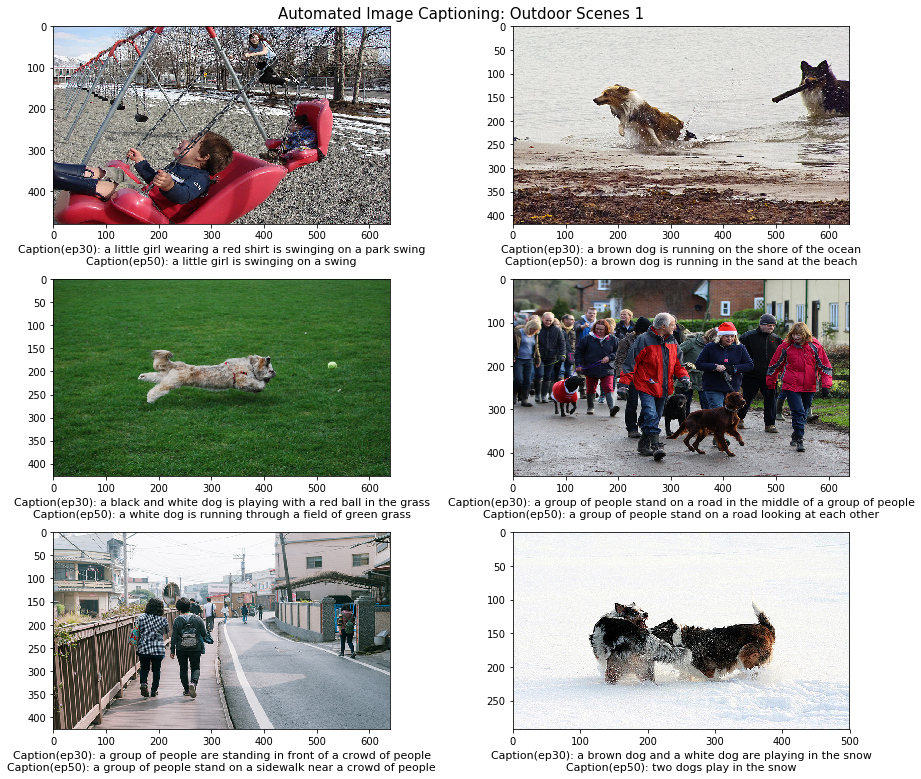

In [110]:
fig=plt.figure(figsize=(13, 11))
plt.suptitle('Automated Image Captioning: Outdoor Scenes 1', verticalalignment='top', size=15)
columns = 2
rows = 3
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    image_name = outdoor1_files[i-1]
    img = image.load_img(image_name)
    plt.imshow(img, aspect='auto')
    modelep30_caption_text = 'Caption(ep30): '+ model30ep_captions_outdoor1[i-1]
    modelep50_caption_text = 'Caption(ep50): '+ model50ep_captions_outdoor1[i-1]
    plt.xlabel(modelep30_caption_text+'\n'+modelep50_caption_text,size=11, wrap=True)
fig.tight_layout()
plt.subplots_adjust(top=0.955)

In [111]:
outdoor2_files = glob.glob('real_test/outdoor2/*')

cg1 = CaptionGenerator(image_locations=outdoor2_files, word_to_index_map=word_to_index, index_to_word_map=index_to_word, 
                       max_caption_size=max_caption_size, caption_model=model1, beam_size=3)
cg2 = CaptionGenerator(image_locations=outdoor2_files, word_to_index_map=word_to_index, index_to_word_map=index_to_word, 
                       max_caption_size=max_caption_size, caption_model=model2, beam_size=3)

cg1.initialize_model()
cg1.process_images()
cg1.generate_captions()
cg2.initialize_model()
cg2.process_images()
cg2.generate_captions()

model30ep_captions_outdoor2 = cg1.captions
model50ep_captions_outdoor2 = cg2.captions

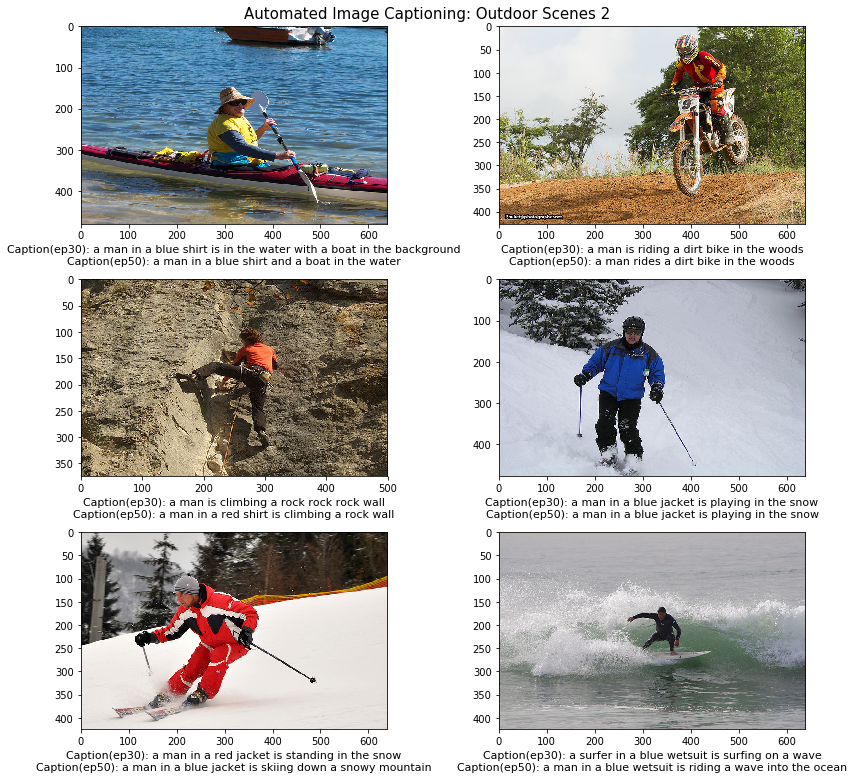

In [117]:
fig=plt.figure(figsize=(12, 11))
plt.suptitle('Automated Image Captioning: Outdoor Scenes 2', verticalalignment='top', size=15)
columns = 2
rows = 3
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    image_name = outdoor2_files[i-1]
    img = image.load_img(image_name)
    plt.imshow(img, aspect='auto')
    modelep30_caption_text = 'Caption(ep30): '+ model30ep_captions_outdoor2[i-1]
    modelep50_caption_text = 'Caption(ep50): '+ model50ep_captions_outdoor2[i-1]
    plt.xlabel(modelep30_caption_text+'\n'+modelep50_caption_text,size=11, wrap=False)
fig.tight_layout()
plt.subplots_adjust(top=0.955)

In [113]:
sports1_files = glob.glob('real_test/sports1/*')

cg1 = CaptionGenerator(image_locations=sports1_files, word_to_index_map=word_to_index, index_to_word_map=index_to_word, 
                       max_caption_size=max_caption_size, caption_model=model1, beam_size=3)
cg2 = CaptionGenerator(image_locations=sports1_files, word_to_index_map=word_to_index, index_to_word_map=index_to_word, 
                       max_caption_size=max_caption_size, caption_model=model2, beam_size=3)

cg1.initialize_model()
cg1.process_images()
cg1.generate_captions()
cg2.initialize_model()
cg2.process_images()
cg2.generate_captions()

model30ep_captions_sports1 = cg1.captions
model50ep_captions_sports1 = cg2.captions

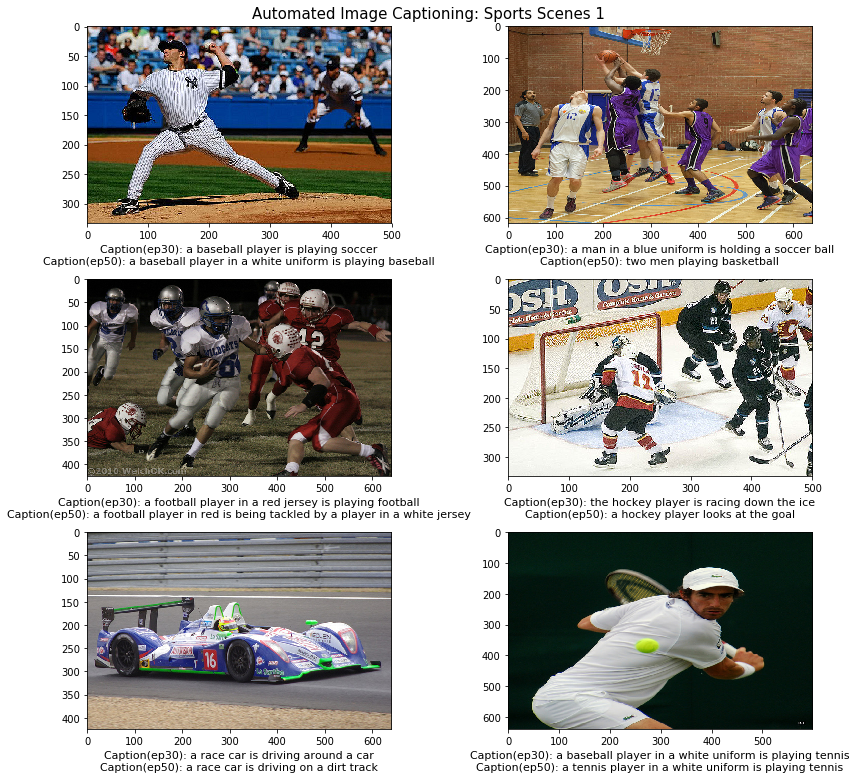

In [118]:
fig=plt.figure(figsize=(12, 11))
plt.suptitle('Automated Image Captioning: Sports Scenes 1', verticalalignment='top', size=15)
columns = 2
rows = 3
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    image_name = sports1_files[i-1]
    img = image.load_img(image_name)
    plt.imshow(img, aspect='auto')
    modelep30_caption_text = 'Caption(ep30): '+ model30ep_captions_sports1[i-1]
    modelep50_caption_text = 'Caption(ep50): '+ model50ep_captions_sports1[i-1]
    plt.xlabel(modelep30_caption_text+'\n'+modelep50_caption_text,size=11, wrap=False)
fig.tight_layout()
plt.subplots_adjust(top=0.955)

In [119]:
sports2_files = glob.glob('real_test/sports2/*')

cg1 = CaptionGenerator(image_locations=sports2_files, word_to_index_map=word_to_index, index_to_word_map=index_to_word, 
                       max_caption_size=max_caption_size, caption_model=model1, beam_size=3)
cg2 = CaptionGenerator(image_locations=sports2_files, word_to_index_map=word_to_index, index_to_word_map=index_to_word, 
                       max_caption_size=max_caption_size, caption_model=model2, beam_size=3)

cg1.initialize_model()
cg1.process_images()
cg1.generate_captions()
cg2.initialize_model()
cg2.process_images()
cg2.generate_captions()

model30ep_captions_sports2 = cg1.captions
model50ep_captions_sports2 = cg2.captions

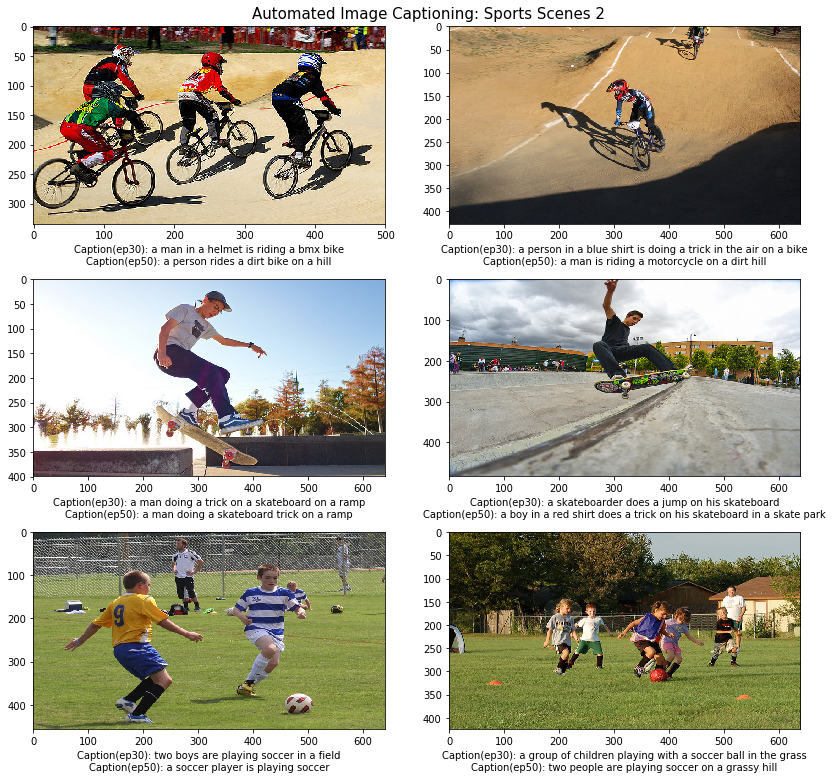

In [120]:
fig=plt.figure(figsize=(12, 11))
plt.suptitle('Automated Image Captioning: Sports Scenes 2', verticalalignment='top', size=15)
columns = 2
rows = 3
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    image_name = sports2_files[i-1]
    img = image.load_img(image_name)
    plt.imshow(img, aspect='auto')
    modelep30_caption_text = 'Caption(ep30): '+ model30ep_captions_sports2[i-1]
    modelep50_caption_text = 'Caption(ep50): '+ model50ep_captions_sports2[i-1]
    plt.xlabel(modelep30_caption_text+'\n'+modelep50_caption_text,size=10, wrap=False)
fig.tight_layout()
plt.subplots_adjust(top=0.955)